# Data Preparation

During today and following days, we will have a set of exercises about the data with UFO sightings around the world. At the end, we will create a machine learning model that will predict how long we can see the UFO based on the characteristics of a sighting.

Now, in this file, we are going to focus on data preparation. Try to replicate the steps from the tutorial, become familiar with the information and variables in the data and prepare it for the next phase, feature engineering.

You can download the data from [**here**](https://drive.google.com/open?id=0B2gZvn36c5CmRTJpS3pkUllmX1U).

In [987]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats
from scipy.stats import boxcox

# SCALING
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

In [988]:
data = pd.read_csv('UFO_data.csv', header = 0, sep = ';')

/home/david/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (20,23,26,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [989]:
data.columns

Index(['Unnamed: 0', 'timestamp', 'city', 'state', 'country', 'shape',
       'duration_seconds', 'duration_text', 'notes', 'date_reported', 'lat',
       'lng', 'date_event', 'apparentTemperature', 'cloudCover',
       'cloudCoverError', 'dewPoint', 'dewPointError', 'humidity',
       'humidityError', 'icon', 'precipIntensity', 'precipProbability',
       'precipType', 'pressure', 'pressureError', 'summary', 'temperature',
       'temperatureError', 'time', 'visibility', 'visibilityError',
       'windBearing', 'windBearingError', 'windSpeed', 'windSpeedError',
       'ast_absolute_magnitude_h', 'ast_estimated_diameter',
       'ast_is_dangerous', 'ast_miss_distance', 'ast_orbiting_body',
       'ast_relative_velocity'],
      dtype='object')

In [990]:
data = data.drop(['Unnamed: 0'], axis = 1)

In [991]:
data.shape

(80332, 41)

# dropping columns with MOSTLY NaN

In [992]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
pressureError,80303,0.999639
visibilityError,80302,0.999627
cloudCoverError,80302,0.999627
dewPointError,80297,0.999564
humidityError,80297,0.999564
temperatureError,80296,0.999552
windSpeedError,80296,0.999552
windBearingError,80296,0.999552
precipType,66599,0.829047
precipProbability,24498,0.304959


In [993]:
to_drop = list(missing_data[missing_data['Percent']>0.9].index)
to_drop.append('duration_text')
to_drop

['pressureError',
 'visibilityError',
 'cloudCoverError',
 'dewPointError',
 'humidityError',
 'temperatureError',
 'windSpeedError',
 'windBearingError',
 'duration_text']

In [994]:
data_dropped = data.drop(to_drop, axis = 1)
data_dropped.shape

(80332, 32)

# Checking data

<AxesSubplot:>

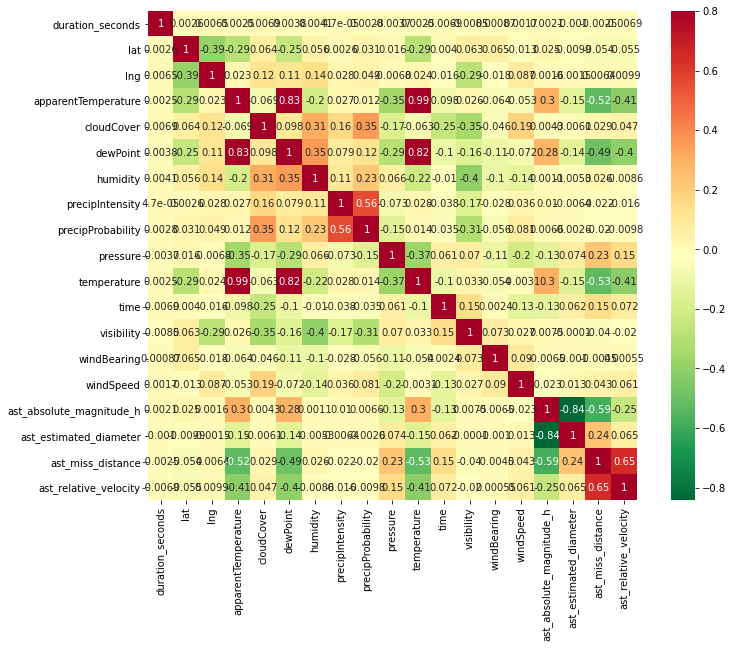

In [995]:
#correlation matrix
corrmat = data_dropped.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8,annot = True, square=True,cmap="RdYlGn_r")

# Dropping not neede columns 

In [999]:
data_dropped.shape

(80332, 32)

In [1000]:
# done need high correlation, and state nor country since we have lat and lng. TIME doenst make sense
high_corr = ['apparentTemperature','dewPoint', 'ast_absolute_magnitude_h', 'state','country', 'time','city']
data_dropped = data_dropped.drop(high_corr, axis = 1)
data_dropped.shape

(80332, 25)

<AxesSubplot:>

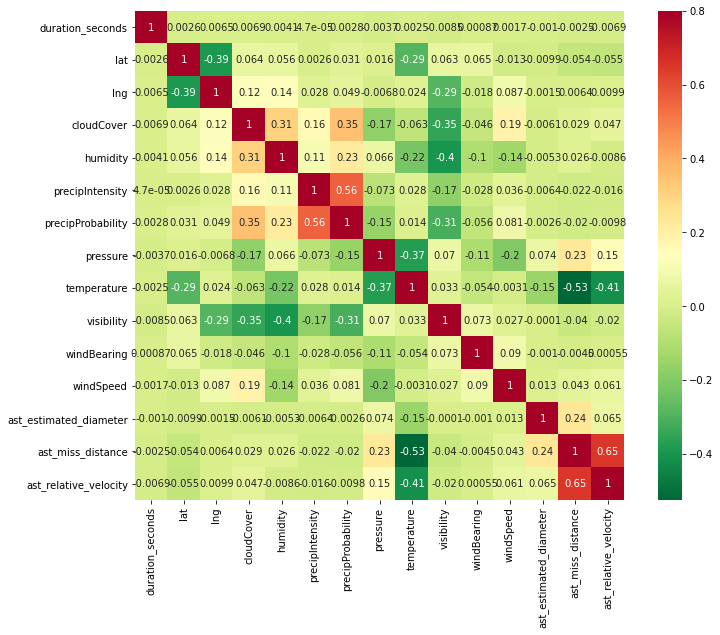

In [1001]:
#correlation matrix
corrmat = data_dropped.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8,annot = True, square=True,cmap="RdYlGn_r")

# Splitting into Numerical and Categorical variable

In [1002]:
# 26 types left after dropping columns
data_dropped.dtypes

timestamp                  object
shape                      object
duration_seconds          float64
notes                      object
date_reported              object
lat                       float64
lng                       float64
date_event                 object
cloudCover                float64
humidity                  float64
icon                       object
precipIntensity           float64
precipProbability         float64
precipType                 object
pressure                  float64
summary                    object
temperature               float64
visibility                float64
windBearing               float64
windSpeed                 float64
ast_estimated_diameter    float64
ast_is_dangerous           object
ast_miss_distance         float64
ast_orbiting_body          object
ast_relative_velocity     float64
dtype: object

In [1003]:
# 15 numerical
numerical = list(data_dropped.dtypes[data_dropped.dtypes != 'object'].index)

# 10 categorical
categorical = list(data_dropped.dtypes[data_dropped.dtypes == 'object'].index)

# Imputing values

In [1006]:
data_dropped.shape

(80332, 25)

### Numerical

In [1007]:
data_num = data_dropped[numerical]
data_num.isnull().sum().sort_values(ascending = False)

precipProbability         24498
precipIntensity           24498
pressure                  16571
cloudCover                16530
windBearing               16039
windSpeed                 15982
visibility                15739
humidity                  15624
temperature               15589
ast_relative_velocity       451
ast_miss_distance           451
ast_estimated_diameter      451
lng                           0
lat                           0
duration_seconds              0
dtype: int64

In [1008]:
# Drop rows if ast_columns are Nan, since ~400 is less than 1% of overall data
data_dropped = data_dropped.dropna(subset=['ast_relative_velocity', 'ast_miss_distance', 'ast_estimated_diameter'])

In [1009]:
# imputing with means or mode
data_dropped['temperature'] = data_dropped['temperature'].fillna(data_dropped['temperature'].mean()) # mean
data_dropped['humidity'] = data_dropped['humidity'].fillna(data_dropped['humidity'].mean()) # mean
data_dropped['visibility'] = data_dropped['visibility'].fillna(data_dropped['visibility'].mode()[0]) # mode
data_dropped['windSpeed'] = data_dropped['windSpeed'].fillna(data_dropped['windSpeed'].mode()[0]) # mode
data_dropped['windBearing'] = data_dropped['windBearing'].fillna(190) # tri-modal, hard to impute the statistics
data_dropped['cloudCover'] = data_dropped['cloudCover'].fillna(data_dropped['cloudCover'].mode()[0]) # mode
data_dropped['pressure'] = data_dropped['pressure'].fillna(data_dropped['pressure'].mean()) # mean
data_dropped['precipIntensity'] = data_dropped['precipIntensity'].fillna(data_dropped['precipIntensity'].mode()[0]) # mode
data_dropped['precipProbability'] = data_dropped['precipProbability'].fillna(data_dropped['precipProbability'].mode()[0]) # mode

In [1010]:
#sns.distplot(boxcox(data_dropped['windSpeed'] + (min(data_dropped['windSpeed'])) + 1,0))
#sns.distplot(boxcox(data_dropped['precipProbability']+ (min(data_dropped['precipProbability'])) + 1, 0))


#sns.distplot(data_dropped['precipProbability'])

### Categorical

In [1011]:
data_cat = data_dropped[categorical]
data_cat.isnull().sum().sort_values(ascending = False)

precipType           66148
summary              15122
icon                 15122
shape                 1923
timestamp              693
notes                   15
ast_orbiting_body        0
ast_is_dangerous         0
date_event               0
date_reported            0
dtype: int64

In [1013]:
# Imputing
data_dropped['precipType'] = data_dropped['precipType'].fillna("None") # either rain, snow or Nan. So Nan mgiht mean no preicp
data_dropped['notes'] = data_dropped['notes'].fillna("None") # only 15 rows, and notes is just summary
data_dropped['shape'] = data_dropped['shape'].fillna(data_dropped['shape'].mode()[0]) # impute with the mode: "light" 
data_dropped['summary'] = data_dropped['summary'].fillna("None") # fill None, just description of weather
data_dropped['icon'] = data_dropped['icon'].fillna("None") # fill None, just description of weather

In [1014]:
# Dropping rows
data_dropped= data_dropped.dropna(subset=['timestamp']) # drop rows with no timestamp (693 rows) ~0.8% of total data

<AxesSubplot:>

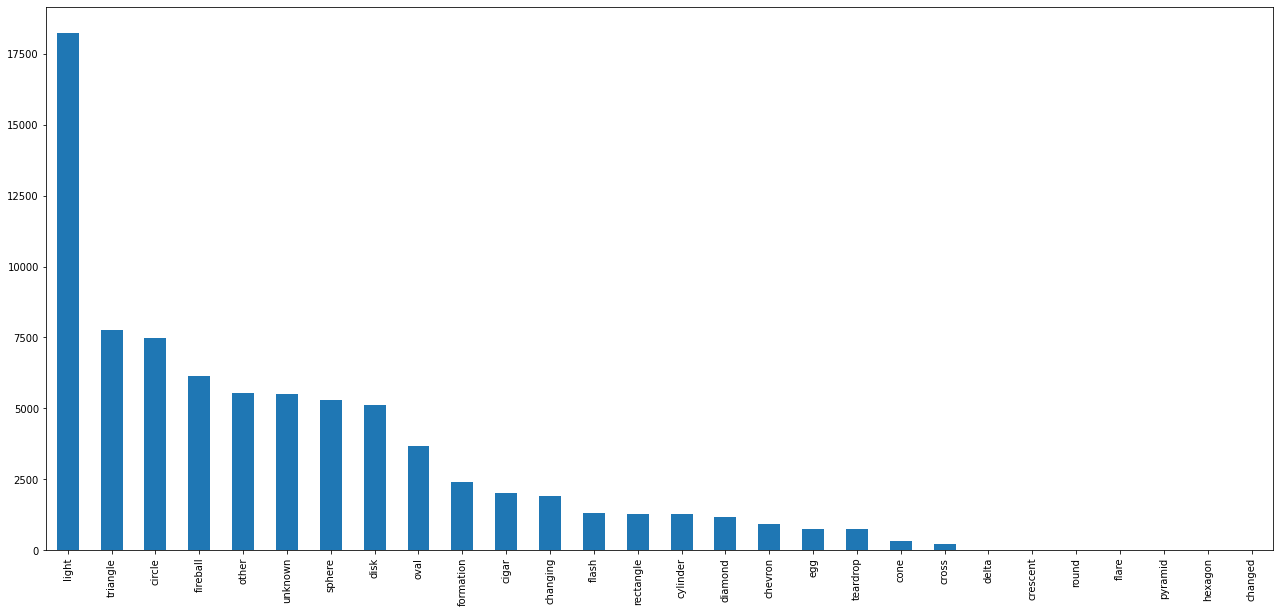

In [1015]:
f, ax = plt.subplots(figsize=(22, 10))
data_dropped['shape'].value_counts().plot(kind='bar')

In [1016]:
data_dropped = data_dropped.reset_index(drop=True)
data_dropped.shape

(79188, 25)

In [1017]:
data_dropped.isnull().sum()

timestamp                 0
shape                     0
duration_seconds          0
notes                     0
date_reported             0
lat                       0
lng                       0
date_event                0
cloudCover                0
humidity                  0
icon                      0
precipIntensity           0
precipProbability         0
precipType                0
pressure                  0
summary                   0
temperature               0
visibility                0
windBearing               0
windSpeed                 0
ast_estimated_diameter    0
ast_is_dangerous          0
ast_miss_distance         0
ast_orbiting_body         0
ast_relative_velocity     0
dtype: int64

# Outliers

In [1018]:
data_num.isnull().sum().sort_values(ascending = False)

precipProbability         24498
precipIntensity           24498
pressure                  16571
cloudCover                16530
windBearing               16039
windSpeed                 15982
visibility                15739
humidity                  15624
temperature               15589
ast_relative_velocity       451
ast_miss_distance           451
ast_estimated_diameter      451
lng                           0
lat                           0
duration_seconds              0
dtype: int64

# looking at boxplots and removing extremem outliers

In [1019]:
data_outlier = data_dropped
data_outlier.shape

(79188, 25)

<AxesSubplot:xlabel='ast_relative_velocity', ylabel='duration_seconds'>

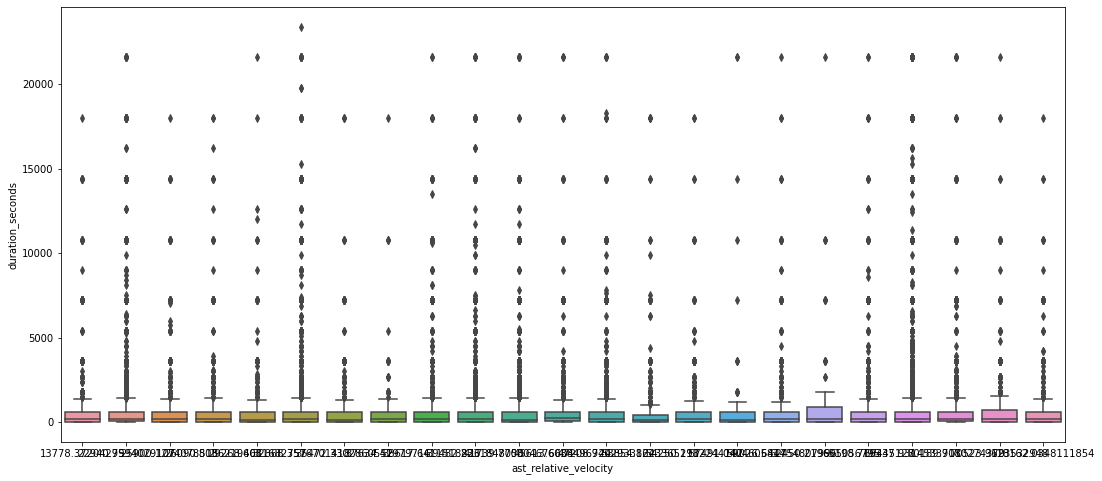

In [949]:
fig, ax = plt.subplots(figsize=(18,8))
sns.boxplot('ast_relative_velocity', "duration_seconds", data=data_outlier)

In [1020]:
# cloudCover: duration_second over 20000000 were extreme       # removed 6
data_outlier = data_outlier.drop(data_outlier[(data_outlier['duration_seconds']>20000000)].index)
data_outlier = data_outlier.reset_index(drop=True)

In [1021]:
# humidity: duration_second over 3000000 were extreme          # removed 16
data_outlier = data_outlier.drop(data_outlier[(data_outlier['duration_seconds']>3000000)].index)
data_outlier = data_outlier.reset_index(drop=True)

In [1022]:
# precipIntensity: duration_second over 5000000 or precipintensity > 30 were extreme          #removed 38
data_outlier = data_outlier.drop(data_outlier[(data_outlier['duration_seconds']>500000)].index)
data_outlier = data_outlier.reset_index(drop=True)

data_outlier = data_outlier.drop(data_outlier[(data_outlier['precipIntensity']>30)].index)
data_outlier = data_outlier.reset_index(drop=True)

In [1023]:
# precipProbability: duration_second over 100000 were extreme          #removed 104
data_outlier = data_outlier.drop(data_outlier[(data_outlier['duration_seconds']>100000)].index)
data_outlier = data_outlier.reset_index(drop=True)

In [1024]:
# pressure: duration_second over 400000 were extreme            # removed 80
data_outlier = data_outlier.drop(data_outlier[(data_outlier['duration_seconds']>40000)].index)
data_outlier = data_outlier.reset_index(drop=True)

In [ ]:
# temperature: ?????

In [ ]:
# visibility: ?????    

In [ ]:
# windBearing: ?????         

In [ ]:
#windSpeed:   ??????

In [1025]:
# ast_estimated_diameter: duration_second over 25000 were extreme            removed 158
data_outlier = data_outlier.drop(data_outlier[(data_outlier['duration_seconds']>25000)].index)
data_outlier = data_outlier.reset_index(drop=True)

In [ ]:
#ast_relative_velocity     
#ast_miss_distance         

In [1026]:
data_outlier.shape

(78786, 25)

In [1027]:
data_outlier

,timestamp,shape,duration_seconds,notes,date_reported,lat,lng,date_event,cloudCover,humidity,...,summary,temperature,visibility,windBearing,windSpeed,ast_estimated_diameter,ast_is_dangerous,ast_miss_distance,ast_orbiting_body,ast_relative_velocity
0,1949-10-10 20:30:00,cylinder,2700.0,This event took place in early fall around 194...,2004-04-27 00:00:00,29.883056,-97.941111,1949-10-10,0.00,0.730000,...,Clear,25.860000,16.09,154.0,4.89,0.297879,True,42621696.0,Earth,13778.372043
1,1949-10-10 21:00:00,light,7200.0,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16 00:00:00,29.384210,-98.581082,1949-10-10,0.00,0.770000,...,Clear,26.120000,16.09,135.0,6.60,0.297879,True,42621696.0,Earth,13778.372043
2,1955-10-10 17:00:00,circle,20.0,Green/Orange circular disc over Chester&#44 En...,2008-01-21 00:00:00,53.200000,-2.916667,1955-10-10,0.75,0.840000,...,Foggy,15.560000,2.90,190.0,2.24,0.297879,True,42621696.0,Earth,13778.372043
3,1956-10-10 21:00:00,circle,20.0,My older brother and twin sister were leaving ...,2004-01-17 00:00:00,28.978333,-96.645833,1956-10-10,0.12,0.710000,...,Clear,22.680000,16.09,136.0,2.75,0.297879,True,42621696.0,Earth,13778.372043
4,1960-10-10 20:00:00,light,900.0,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22 00:00:00,21.418056,-157.803611,1960-10-10,0.63,0.770000,...,Mostly Cloudy,25.740000,16.09,80.0,3.60,0.297879,True,42621696.0,Earth,13778.372043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78781,2013-09-07 23:00:00,light,300.0,Ufos in Phillipsburg NJ? I believe&#33&#33,2013-09-09 00:00:00,40.693611,-75.190556,2013-09-07,0.00,0.660547,...,None,13.496951,16.09,190.0,2.24,0.056760,False,3610758.0,Earth,32868.357670
78782,2013-09-07 23:00:00,fireball,300.0,Bright Red light object with no sound moved sl...,2013-09-09 00:00:00,47.483056,-122.215833,2013-09-07,0.00,0.660547,...,None,13.496951,16.09,190.0,2.24,0.056760,False,3610758.0,Earth,32868.357670
78783,2013-09-07 23:15:00,circle,10.0,Orange/white circle travels at alarming speed ...,2013-09-09 00:00:00,38.232500,-122.635556,2013-09-07,0.00,0.660547,...,None,13.496951,16.09,190.0,2.24,0.056760,False,3610758.0,Earth,32868.357670
78784,2013-09-07 23:30:00,unknown,180.0,Glowing orange light in the night sky.,2013-09-09 00:00:00,40.499167,-74.399444,2013-09-07,0.00,0.660547,...,None,13.496951,16.09,190.0,2.24,0.056760,False,3610758.0,Earth,32868.357670


# Feature Engineering

In [1028]:
data_outlier.to_csv('UFO_cleaned.csv')